In [4]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
import pycatch22 as catch22
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer, LabelEncoder
from metric_learn import MMC_Supervised
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from collections import defaultdict
import palettable
import seaborn as sns
import matplotlib as mpl
import pickle
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
from pysindy.feature_library import CustomLibrary, GeneralizedLibrary, TensoredLibrary
from sklearn.metrics import log_loss
import sdeint
import sympy as smp
from sympy import real_roots

In [192]:
def gen_hopf(num_samples, seed=32): # num samples
    np.random.seed(seed)
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, 5, size=num_samples)
    N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    sols_list = list()
    dt = 0.01
    lengths = list()
    regime = list()
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        if mu > 0:
            regime.append('Hopf Limit Cycle')
        else:
            regime.append('Hopf Fixed Point')
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = regime
    return sols_list, df

In [193]:
ts_hopf, df_hopf = gen_hopf(5000)

In [181]:
def gen_hookes(num_samples, seed=12):
    np.random.seed(seed)
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-5, -0.01, size=num_samples)
    N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    sols_list = list()
    dt = 0.01
    lengths = list()
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
    features_hookes = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'Hookes Fixed Point'
    return sols_list, df_hookes

In [182]:
ts_hookes, df_hookes = gen_hookes(5000)

In [114]:
def gen_bistable(num_samples, seed=93):
    np.random.seed(seed)
    eta_val_bistable = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_bistable = np.random.uniform(-5, 5, size=num_samples)
    N_val_bistable  = np.random.randint(50, 5000, size=num_samples)
    sols_list = list()
    dt = 0.01
    lengths = list()
    regime_list = list()
    for i in range(num_samples):
        N_val = N_val_bistable[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
        lengths.append(len(sol[500:]))
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            regime_list.append('Bistable Switching')
        else:
            regime_list.append('Bistable Fixed Point')

    features_bistable = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = lengths
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['regime'] = regime_list
    return sols_list, df_bistable

In [117]:
ts_bistable, df_bistable = gen_bistable(5000)

In [194]:
ts_all = ts_hopf + ts_hookes + ts_bistable
df_all = pd.concat((df_hopf, df_hookes, df_bistable), ignore_index=True)

In [198]:
df_all['regime'].value_counts()

Hookes Fixed Point      5000
Bistable Fixed Point    4873
Hopf Limit Cycle        2562
Hopf Fixed Point        2438
Bistable Switching       127
Name: regime, dtype: int64

Add an additional label for model independent generic dynamical behaviours

In [199]:
replace_values = {'Hookes Fixed Point' : 'Fixed Point', 
                  'Bistable Fixed Point' : 'Fixed Point',
                  'Hopf Fixed Point' : 'Fixed Point',
                  'Hopf Limit Cycle' : 'Limit Cycle',
                  'Bistable Switching' : 'Switching'}
df_all['behaviour'] = df_all['regime'].replace(replace_values)

In [200]:
rs = RobustScaler().fit(df_all.iloc[:,:22])
rs_fit = rs.transform(df_all.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)
xhat = mm_fit

In [201]:
pca_viz = PCA(n_components=2).fit(xhat)
pca_embeddings = pca_viz.transform(xhat)
pca_df = pd.DataFrame(pca_embeddings, columns=['PC1', 'PC2'])
pca_df['regime'] = df_all['regime']
pca_df['behaviour'] = df_all['behaviour']
pca_df['N'] = df_all['N']
pca_df['mu'] = df_all['mu']
pca_df['eta'] = df_all['eta']

In [202]:
pca_df['behaviour'].value_counts()

Fixed Point    12311
Limit Cycle     2562
Switching        127
Name: behaviour, dtype: int64

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 7 Text major ticklabel objects>)

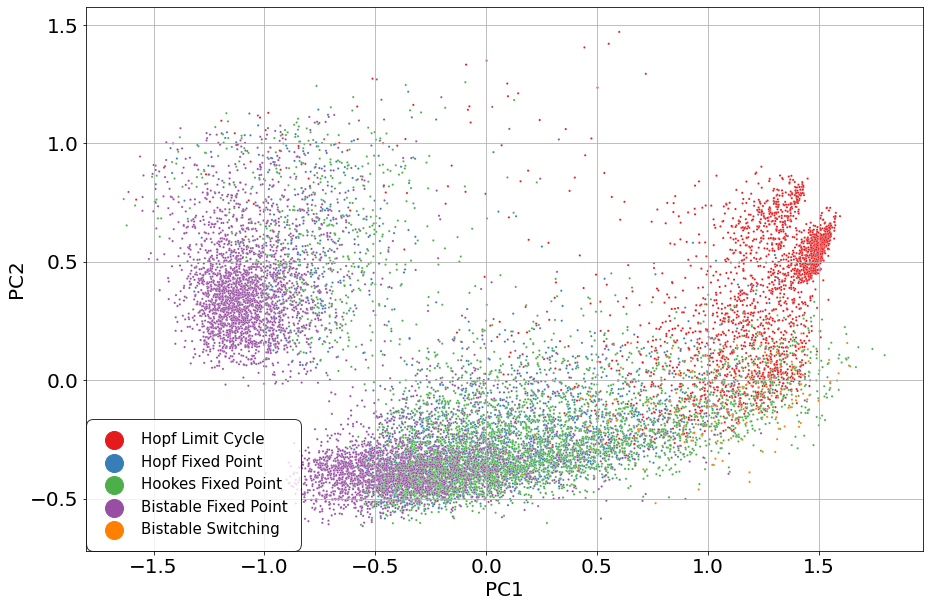

In [203]:
plt.figure(figsize=(15, 10))
#sns.kdeplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['regime'], alpha=0.2, palette='Set1', levels=20)
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['regime'], s=5, palette='Set1')
plt.grid()

legend = plt.legend(fontsize=15, frameon=True, loc='lower left', markerscale=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_boxstyle('round,pad=0.5')

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [348]:
df_normalised = pd.DataFrame(xhat)
df_normalised['regime'] = df_all['regime']
df_normalised['behaviour'] = df_all['behaviour']
df_normalised['N'] = df_all['N']
df_normalised['mu'] = df_all['mu']
df_normalised['eta'] = df_all['eta']


Test projections, trivial case

1. Hopf LC Long and Noisy

In [162]:
def gen_hopf_single(eta, mu, N, seed=354): # num samples
    np.random.seed(seed)
    # hopf
    eta_val_hopf = eta
    mu_val_hopf = mu
    N_val_hopf  = N
    sols_list = list()
    dt = 0.01
    lengths = list()
    regime = list()
    for i in range(1):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        if mu > 0:
            regime.append('Hopf Limit Cycle')
        else:
            regime.append('Hopf Fixed Point')
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['regime'] = regime
    return sols_list, df

In [204]:
ts_hopf_test1, df_hopf_test1 = gen_hopf_single(eta=[0.8], mu=[1], N=[5000])

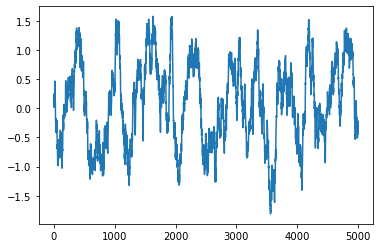

In [205]:
plt.plot(ts_hopf_test1[0])

Project and predict

In [209]:
xhat_hopf_test1 = mm.transform(sigmoid_transformer.transform(rs.transform(df_hopf_test1.iloc[:,:22])))
embedding_hopf_test1 = pca_viz.transform(xhat_hopf_test1)

(array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ]),
 <a list of 7 Text major ticklabel objects>)

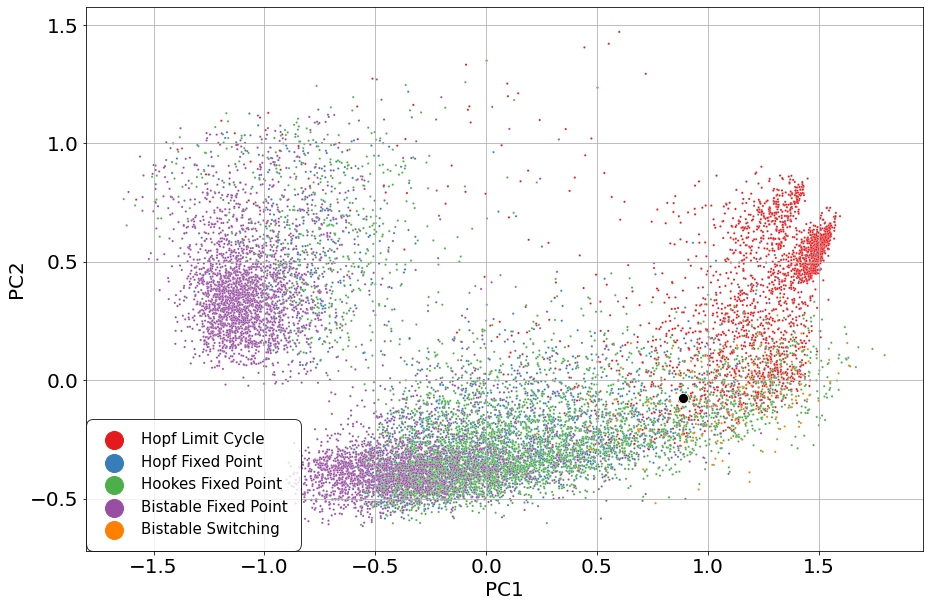

In [214]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['regime'], s=5, palette='Set1')
sns.scatterplot(x=embedding_hopf_test1[:,0], y=embedding_hopf_test1[:,1], s=100, color='black')

plt.grid()

legend = plt.legend(fontsize=15, frameon=True, loc='lower left', markerscale=3)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_boxstyle('round,pad=0.5')

plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#### Compute pairwise distances

# Alternative sampling

In [218]:
def gen_limitCycle(num_samples, seed=34): # num samples
    np.random.seed(seed)
    # hopf
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    sols_list = list()
    lengths = list()
    dt = 0.01
    print('Generating Limit Cycle Instances...')
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_hopf)
    df['N'] = lengths
    df['mu'] = mu_val_hopf
    df['eta'] = eta_val_hopf
    df['model'] = 'Hopf'
    df['regime'] = 'Limit Cycle'
    return ts_hopf, df

In [298]:
ts_lc, df_lc = gen_limitCycle(2000)

Generating Limit Cycle Instances...


In [248]:
def gen_fixedpoint(num_samples, seed=342):
    num_samples = num_samples // 3
    np.random.seed(seed)
    #system 1 - hookes
    eta_val_hookes = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hookes = np.random.uniform(-5, -0.01, size=num_samples)
    N_val_hookes  = np.random.randint(50, 5000, size=num_samples)
    sols_list_hookes = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_hookes[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list_hookes.append(sol[500:, 0])
        lengths.append(len(sol[500:, 0]))
    features_hookes = np.array([catch22.catch22_all(sols_list_hookes[i])['values'] for i in range(len(sols_list_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['model'] = 'Hookes'
    df_hookes['regime'] = 'Fixed Point'

    # system 2 - hopf 
    eta_val_hopf = np.random.uniform(0.01, 1, size=num_samples)
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    N_val_hopf  = np.random.randint(50, 5000, size=num_samples)
    sols_list_hopf = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_hopf[i]
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list_hopf.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list_hopf[i])['values'] for i in range(len(sols_list_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['model'] = 'Hopf'
    df_hopf['regime'] = 'Fixed Point'

    # system 3 - bistable

    eta_val_bistable = list()
    mu_val_bistable = list()
    N_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-5, 5)
        n = np.random.randint(50, 5000)
        l = ((n+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = np.random.uniform(0.01, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if not (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            N_val_bistable.append(n)
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = N_val_bistable
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Fixed Point'

    ts_fixedpt = sols_list_hookes + sols_list_hopf + sols_list_bistable
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable], ignore_index=True)


    return ts_fixedpt, df_fixedpt

In [299]:
ts_fixedpt, df_fixedpt = gen_fixedpoint(num_samples=2000)

In [300]:
df_fixedpt['model'].value_counts()

Hookes      666
Hopf        666
Bistable    666
Name: model, dtype: int64

In [255]:
def gen_switching(num_samples, seed=98): # num samples 
    np.random.seed(seed)
    eta_val_bistable = list()
    mu_val_bistable = list()
    N_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-0.384, 0.384)
        n = np.random.randint(500, 5000)
        l = ((n+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = np.random.uniform(0.2, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            N_val_bistable.append(n)
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['N'] = N_val_bistable
    df_bistable['mu'] = mu_val_bistable
    df_bistable['eta'] = eta_val_bistable
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Switching'
    return sols_list_bistable, df_bistable

In [301]:
ts_switching, df_switching = gen_switching(num_samples=2000)

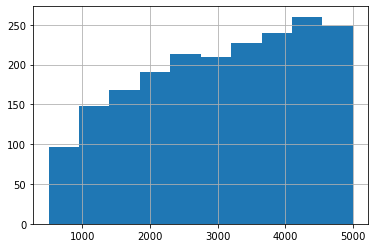

In [303]:
df_switching['N'].hist()

In [309]:
df_combined_regimes = pd.concat([df_lc, df_fixedpt, df_switching], ignore_index=True)
ts_combined_regimes = ts_lc + ts_fixedpt + ts_switching

In [310]:
rs = RobustScaler().fit(df_combined_regimes.iloc[:,:22])
rs_fit = rs.transform(df_combined_regimes.iloc[:,:22])
def sigmoid(x, theta):
    return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 0.8})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
mm_fit = mm.transform(sigmoid_fit)

In [311]:
pca_fit = PCA(n_components=2).fit(mm_fit)
pca = pca_fit.transform(mm_fit)

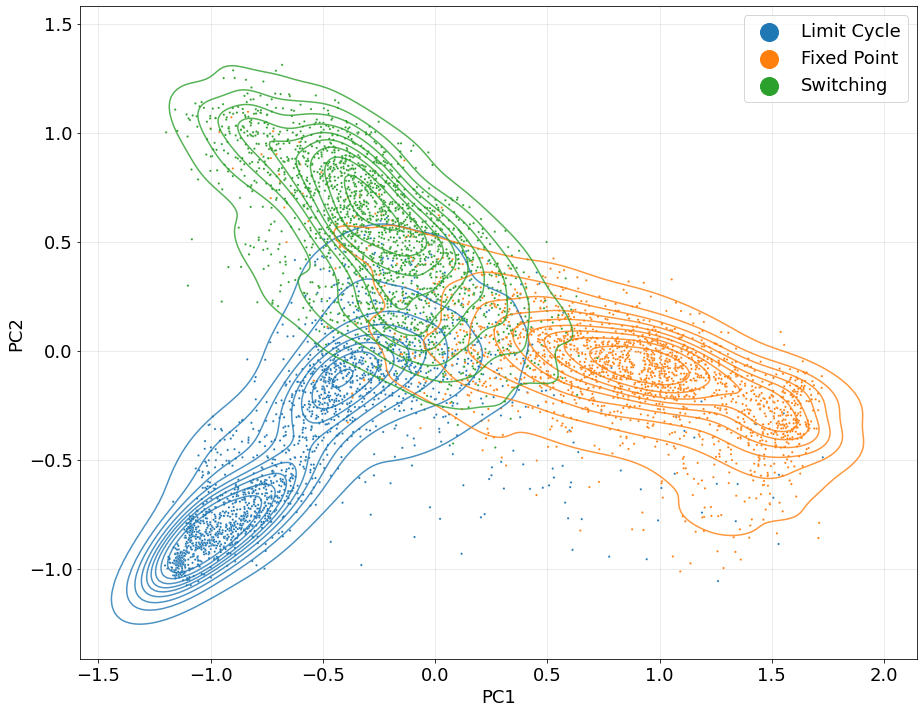

In [330]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.kdeplot(x=pca[:,0], y=pca[:,1], levels=10, hue=df_combined_regimes['regime'], alpha=0.8)
sns.scatterplot(x=pca[:,0], y=pca[:,1], s=5, hue=df_combined_regimes['regime'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.legend(markerscale=3, fontsize=18)
plt.savefig('alternative_sampling_generic_behaviour.png', dpi=400, bbox_inches='tight', transparent=True)
plt.show()

In [319]:
df_combined_regimes['model_regime'] = df_combined_regimes['model'] + " " + df_combined_regimes['regime']

In [414]:
df_train_fit = pd.DataFrame(mm_fit)

In [416]:
df_train_fit['model_regime'] = df_combined_regimes['model_regime']

In [418]:
df_train_fit['regime'] = df_combined_regimes['regime']

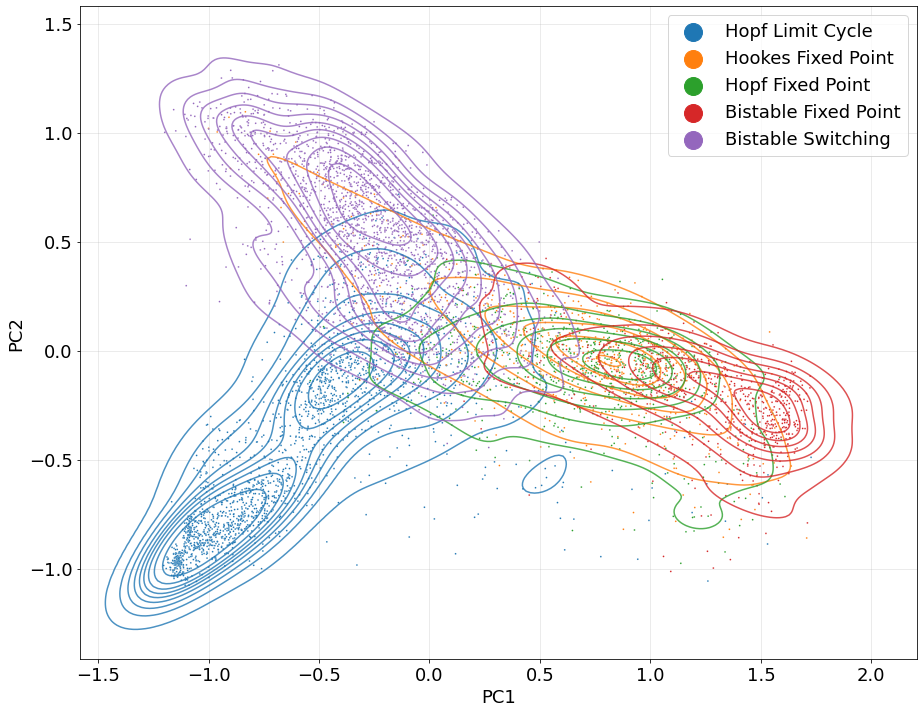

In [336]:
plt.figure(figsize=(15,12))
plt.grid(alpha=0.3)
sns.kdeplot(x=pca[:,0], y=pca[:,1], levels=10, hue=df_combined_regimes['model_regime'], alpha=0.8)
sns.scatterplot(x=pca[:,0], y=pca[:,1], s=3, hue=df_combined_regimes['model_regime'])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.legend(markerscale=3, fontsize=18)
plt.savefig('alternative_sampling_model_regime.png', dpi=400, bbox_inches='tight', transparent=True)
#plt.show()

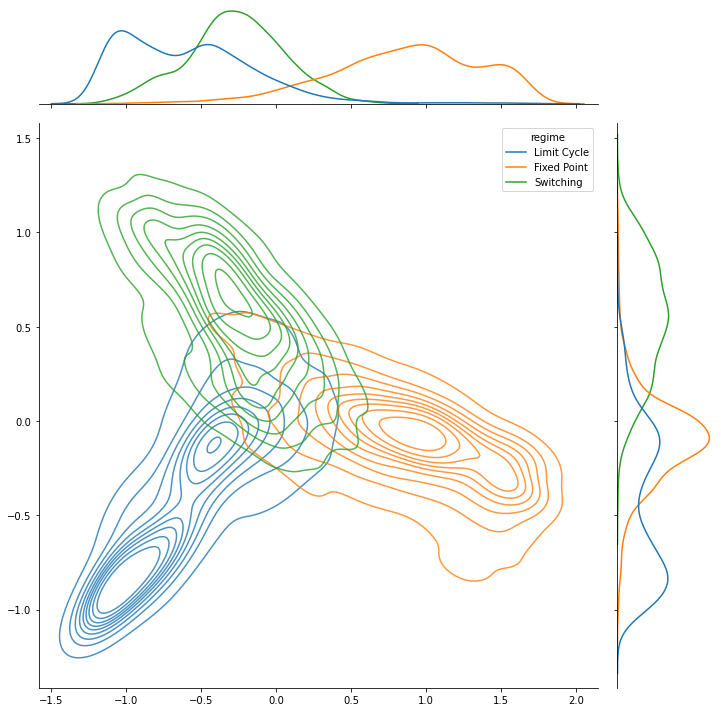

In [331]:
sns.jointplot(x=pca[:,0], y=pca[:,1], kind='kde', hue=df_combined_regimes['regime'], alpha=0.8, height=10)
plt.savefig('alternative_sampling_generic_behaviour_jointplot.png', dpi=400, bbox_inches='tight', transparent=True)

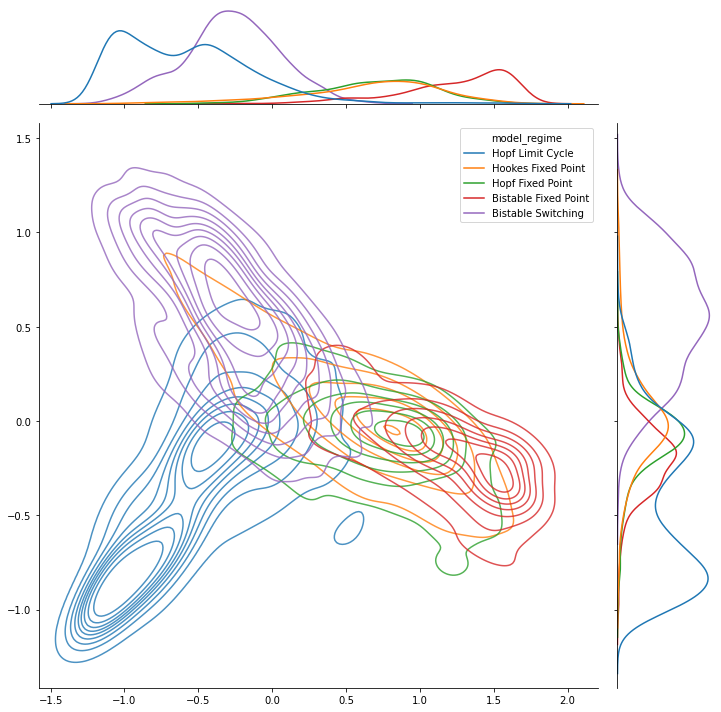

In [335]:
sns.jointplot(x=pca[:,0], y=pca[:,1], kind='kde', hue=df_combined_regimes['model_regime'], alpha=0.8, height=10)
plt.savefig('alternative_sampling_model_regime_jointplot.png', dpi=400, bbox_inches='tight', transparent=True)

Occam's Razor

Generate data from a Hopf FP and project into space

In [337]:
ts_hopf_test_alt, df_hopf_test_alt = gen_hopf(num_samples=1)

In [339]:
xhat_hopf_test_alt = mm.transform(sigmoid_transformer.transform(rs.transform(df_hopf_test_alt.iloc[:,:22])))

In [342]:
pca_fit.transform(xhat_hopf_test_alt)

array([[0.6247404, 0.034235 ]])

## Epsilon Curves

We will consider how the tolerance epsilon behaves for each QE behaviour. We will explore three noise levels and three lengths.

Case 1: N = 5000, sigma = 0.01 (ideal case) -> here we expect epsilon to give low log loss because many data points to distiguish mechanisms.

In [381]:
def gen_limitCycle_fixedvals(eta_val_fixed, N_val_fixed, num_samples, seed=33544): # num samples
    np.random.seed(seed)
    # hopf
    mu_val_hopf = np.random.uniform(0.01, 5, size=num_samples)
    sols_list = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_fixed
        l = ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_fixed
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list[i])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_hopf)
    df['mu'] = mu_val_hopf
    df['model'] = 'Hopf'
    df['regime'] = 'Limit Cycle'
    return sols_list, df

In [385]:
ts_lc_long_low, df_lc_long_low = gen_limitCycle_fixedvals(eta_val_fixed=0.01, N_val_fixed=5000, num_samples=1000)

In [390]:
def gen_fixedpoint_fixedvals(eta_val_fixed, N_val_fixed, num_samples, seed=342):
    num_samples = num_samples // 3
    np.random.seed(seed)
    #system 1 - hookes
    mu_val_hookes = np.random.uniform(-5, -0.01, size=num_samples)
    sols_list_hookes = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_fixed
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_fixed
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list_hookes.append(sol[500:, 0])
        lengths.append(len(sol[500:, 0]))
    features_hookes = np.array([catch22.catch22_all(sols_list_hookes[i])['values'] for i in range(len(sols_list_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['mu'] = mu_val_hookes
    df_hookes['model'] = 'Hookes'
    df_hookes['regime'] = 'Fixed Point'

    # system 2 - hopf 
    mu_val_hopf = np.random.uniform(-5, -0.01, size=num_samples) # sample 
    sols_list_hopf = list()
    lengths = list()
    dt = 0.01
    for i in range(num_samples):
        N_val = N_val_fixed
        l= ((N_val+500)*dt)
        tspan = np.arange(0, l, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_fixed
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list_hopf.append(sol[500:, 0]) # only return x time series
        lengths.append(len(sol[500:, 0]))
    features_hopf = np.array([catch22.catch22_all(sols_list_hopf[i])['values'] for i in range(len(sols_list_hopf))])
    df_hopf = pd.DataFrame(features_hopf)

    df_hopf['mu'] = mu_val_hopf

    df_hopf['model'] = 'Hopf'
    df_hopf['regime'] = 'Fixed Point'

    # system 3 - bistable

    mu_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-5, 5)
        n = N_val_fixed
        l = ((n+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = eta_val_fixed
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if not (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
 
    df_bistable['mu'] = mu_val_bistable
  
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Fixed Point'

    ts_fixedpt = sols_list_hookes + sols_list_hopf + sols_list_bistable
    df_fixedpt = pd.concat([df_hookes, df_hopf, df_bistable], ignore_index=True)


    return ts_fixedpt, df_fixedpt

In [392]:
ts_fp_long_low, df_fp_long_low = gen_fixedpoint_fixedvals(eta_val_fixed=0.01, N_val_fixed=5000, num_samples=1000, seed=44)

In [398]:
def gen_switching_fixedvals(num_samples,N_val_fixed=5000,  seed=98): # num samples 
    np.random.seed(seed)
    eta_val_bistable = list()
    mu_val_bistable = list()
    N_val_bistable = list()
    sols_list_bistable = list()
    dt = 0.01
    count = 0
    while count < num_samples:
        # run loop until switching instance is generated
        mu = np.random.uniform(-0.384, 0.384)
        l = ((N_val_fixed+500)*dt)
        tspan = np.arange(0, l, dt)
        eta = np.random.uniform(0.2, 1)
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check to see if switching instance is generated
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            # add switching label
            eta_val_bistable.append(eta)
            mu_val_bistable.append(mu)
            sols_list_bistable.append(sol[500:])
            count += 1
    
    features_bistable = np.array([catch22.catch22_all(sols_list_bistable[i])['values'] for i in range(len(sols_list_bistable))])
    df_bistable = pd.DataFrame(features_bistable)
    df_bistable['mu'] = mu_val_bistable
    df_bistable['model'] = 'Bistable'
    df_bistable['regime'] = 'Switching'
    return sols_list_bistable, df_bistable

In [403]:
ts_sw_long_low, df_sw_long_low = gen_switching_fixedvals(num_samples=1000)

In [406]:
df_low_long_combined = pd.concat([df_lc_long_low, df_fp_long_low, df_sw_long_low], ignore_index=True)

In [408]:
ts_low_long_combined = ts_lc_long_low + ts_fp_long_low + ts_sw_long_low

In [427]:
df_low_long_combined

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,mu,model,regime
0,-1.129751,-1.272062,117.314522,311.0,1.435378,-1.030951e-11,0.000000,318.0,0.016602,627.0,...,0.999476,309.0,1.139166,0.734694,0.653061,0.009971,0.020094,2.367403,Hopf,Limit Cycle
1,-1.128798,-1.270764,116.435407,310.0,1.434219,9.439604e-10,0.000000,317.0,0.016602,625.0,...,0.999412,316.0,1.139166,0.734694,0.673469,0.009971,0.020124,4.956844,Hopf,Limit Cycle
2,-1.130309,1.277973,119.069046,313.0,1.433265,-7.077375e-09,0.000000,316.0,0.010406,628.0,...,0.999670,313.0,1.138086,0.734694,0.653061,0.009971,0.019991,4.657490,Hopf,Limit Cycle
3,1.183215,1.331809,117.476975,312.0,1.448788,-3.024879e-08,0.000000,329.0,0.014568,629.0,...,0.999437,256.0,1.139166,0.734694,0.673469,0.009971,0.020620,0.146097,Hopf,Limit Cycle
4,-1.128475,-1.269827,120.422697,314.0,1.432217,-1.666520e-08,0.000000,317.0,0.009018,630.0,...,0.999781,315.0,1.139165,0.755102,0.653061,0.009971,0.019866,4.355640,Hopf,Limit Cycle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,0.807214,-0.936496,288.617804,574.0,1.146445,1.352056e-06,0.618324,1486.0,0.023333,1087.0,...,0.996674,12.0,1.306649,0.163265,0.877551,0.003835,0.098073,-0.032984,Bistable,Switching
2995,0.465415,0.722192,119.717151,359.0,0.819639,-3.031341e-04,0.781356,263.0,0.004167,972.0,...,0.988385,9.0,1.432022,0.755102,0.714286,0.007670,0.183443,0.366852,Bistable,Switching
2996,-0.284295,-0.540177,233.252593,508.0,0.797518,-3.764128e-05,0.733747,621.0,0.005510,1034.0,...,0.992259,13.0,1.469229,0.367347,0.244898,0.005369,0.146719,-0.120269,Bistable,Switching
2997,-0.241248,-0.485047,234.263727,293.0,0.930400,-7.313015e-07,0.667534,811.0,0.054422,1202.0,...,0.994949,19.0,1.378211,0.612245,0.510204,0.003835,0.118603,-0.107163,Bistable,Switching


In [409]:
xhat_low_long = mm.transform(sigmoid_transformer.transform(rs.transform(df_low_long_combined.iloc[:,:22])))

In [425]:
df_xhat_low_long = pd.DataFrame(xhat_low_long)

In [428]:
df_xhat_low_long['regime'] = df_low_long_combined['regime']
df_xhat_low_long['model'] = df_low_long_combined['model']

In [421]:
abc = RadiusNeighborsClassifier(radius=0.1, outlier_label='most_frequent')
abc.fit(df_train_fit.iloc[:, :22], df_train_fit['regime'])

RadiusNeighborsClassifier(outlier_label='most_frequent', radius=0.1)

In [ ]:
epsilons = np.linspace(0.01, 5, 10)
for eps in epsilons:
    abc = RadiusNeighborsClassifier(radius=eps, outlier_label='most_frequent')
    abc.fit(df_train_fit.iloc[:, :22], df_train_fit['model'])
    preds = abc.predict_proba(df_xhat_low_long.iloc[:, :22])
    